# Workflow in dynamiqs

The core of dynamiqs is to solve quantum differential equations. This tutorial goes over the basic workflow of such simulations. There are mainly four steps:
 - **Define the system**: Design the state and operators you are interested in.
 - **Define the scope**: Specify the duration, observables or solver of your simulation.
 - **Run the simulation**: Solve the differential equation and collect the results.
 - **Analyze the results**: Plot results and extract the information you are interested in.

In the rest of this tutorial, we go over these steps in detail, taking the example of the Rabi oscillations of a two-level system.

In [79]:
import torch
import dynamiqs as dq
import matplotlib.pyplot as plt
from math import sqrt

***
## 1. Define the system

After having imported the necessary packages, we can define our system, namely the initial state, the Hamiltonian, and the eventual loss operators. Common states and operators are already defined in dynamiqs, see the [API documentation](../python_api/utils.html) for more details. Otherwise, you can define specific states and operators using [NumPy](https://numpy.org/) arrays, [QuTiP](http://qutip.org/) objects, or [PyTorch](https://pytorch.org/) tensors. 

Here, we will use [`dq.fock`](../python_api/utils/states/fock.html) to define the initial state $\lvert \psi_0 \rangle = \lvert 0 \rangle$, [`dq.sigmaz`](../python_api/utils/operators/sigmaz.html) and [`dq.sigmax`](../python_api/utils/operators/sigmax.html) to define the Hamiltonian $H = \delta \sigma_z + \Omega \sigma_x$.

In [80]:
# initial state
psi0 = dq.fock(2, 0)

# Hamiltonian
delta = 0.3  # detuning
Omega = 1.0  # Rabi frequency
H = delta * dq.sigmaz() + Omega * dq.sigmax()

print(f"State of type {type(psi0)} and shape {psi0.shape}.")
print(f"Hamiltonian of type {type(H)} and shape {H.shape}.")

State of type <class 'torch.Tensor'> and shape torch.Size([2, 1]).
Hamiltonian of type <class 'torch.Tensor'> and shape torch.Size([2, 2]).


In dynamiqs, all quantum objects are defined directly with PyTorch [Tensors](https://pytorch.org/docs/stable/tensors.html), and without subclassing. This allows for easy interfacing with PyTorch utility functions, and avoids runtime overheads. Also, all quantum objects have at least two dimensions to avoid systematic reshaping or coding mistakes (e.g. trying to multiply a ket and an operator in the wrong order).
In particular, kets have a shape `(..., N, 1)`.

## 2. Define the scope

Next, we define the scope of the simulation. This includes the total duration of time evolution, the observables we want to measure and how often we measure them. Observables are defined similarly to the Hamiltonian, using Tensors and dynamiqs utility functions. The total duration and how often measurements are performed is defined in a single object named `t_save`. It is an arbitrary array of time points, of which `t_save[-1]` specifies the total duration of time evolution.

We also need to specify the options related to the solver, namely the method of integration and the eventual related parameters. For instance, fixed step solvers will require the definition of the step size with `options = dict(dt=0.01}`. The list of available solvers and their parameters is available in the [API documentation](../python_api/solvers.html) for each quantum differential equation.

In [81]:
# define sampling times
sim_time = 10.0  # total time of evolution
num_save = 100  # number of time slots to save
t_save = torch.linspace(
    0.0, sim_time, num_save
)  # (can also be a list or a numpy.array)

# define list of observables
exp_ops = [dq.sigmaz()]  # expectation value of sigma_z

# define solver
solver = 'dopri5'  # Dormand-Prince of order 5 (default solver)

# optional solver parameters
options = {
    'rtol': 1e-8,  # relative tolerence of each time step
    'atol': 1e-10,  # absolute tolerence of each time step
    'dtype': torch.complex64,  # data type of the computation
    'device': 'cpu',  # device to perform the computation on
}

## 3. Run the simulation

We can now run the simulation. This is done by calling the [`dq.sesolve`](../python_api/solvers/sesolve.html) function, which returns an instance of the [`Result`](../python_api/solvers.html) class. This object contains the computed states, the observables, and various information about the solver. It also features utility methods to convert result Tensors to NumPy arrays or QuTiP objects.

In [103]:
# run simulation
result = dq.sesolve(H, psi0, t_save, exp_ops=exp_ops, solver=solver, options=options)

# print some information
print(f"`result` is of type {type(result)}.")
print(f"`result` has the following attributes:")
print(f"{[attr for attr in dir(result) if not attr.startswith('__')]}\n")
print(result)

|██████████| 100.0% - time 00:00/00:00

`result` is of type <class 'dynamiqs.solvers.result.Result'>.
`result` has the following attributes:
['end_datetime', 'end_time', 'exp_save', 'expects', 'load', 'meas_save', 'measurements', 'options', 'save', 'solver_str', 'start_datetime', 'start_time', 'states', 'to_numpy', 'to_qutip', 'total_time', 'y_save']

==== Result ====
Method       : Dopri5
Start        : 2023-09-11 13:45:42
End          : 2023-09-11 13:45:42
Total time   : 0.07 s
states       : Tensor (100, 2, 1) | 1.56 Kb
expects      : Tensor (1, 100) | 0.78 Kb


## 4. Analyze the results

Finally, we can analyze the results in whichever relevant way. In our example, let us plot the $\langle \sigma_z \rangle$ observable as a function of time. To do so, we call `result.expects[0].real` which extracts the first measured observable (here, the only one) and plot its real part (our observable is hermitian, so measurements are real-valued). We compare to the expected analytical result.

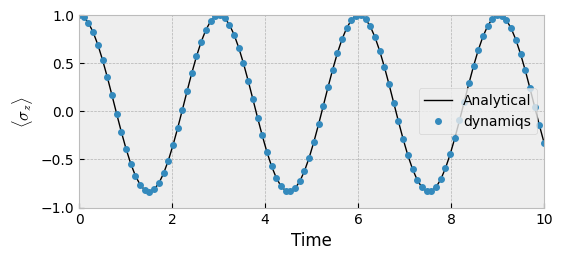

In [95]:
# analytical result
Omega_star = sqrt(delta**2 + Omega**2)  # generalized Rabi frequency
excited_pop = Omega / Omega_star * torch.sin(t_save * Omega_star)  # excited population
sigmaz_analytical = 1 - 2 * excited_pop**2  # expectation value of sigma_z

# plot results
plt.figure(figsize=(6, 2.5))
plt.plot(t_save, sigmaz_analytical, 'k', lw=1.0)
plt.plot(t_save, result.expects[0].real, 'oC0', ms=4)

# formatting
plt.xlabel('Time')
plt.ylabel(r'$\langle \sigma_z \rangle$')
plt.xlim(0, 10)
plt.ylim(-1, 1)
plt.legend(('Analytical', 'dynamiqs'))
plt.style.use('bmh')

# display plot
plt.show()

As expected, we find off-resonant Rabi oscillations at the generalized Rabi frequency $\Omega^* = \sqrt{\delta^2 + \Omega^2}$, and with a reduced amplitude $|\Omega / \Omega^*|^2$.

## Next steps

(Coming soon!)

In the following tutorial, we will dive into the simulation of decoherence and damping using the Lindblad formalism. You can also check out a tutorial on batching to seamlessly run multiple simulations in parallel, or on differentiating through a quantum differential equation to compute gradients.